# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`.
- __1.2__ (2 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here.  Preferably with plot/report to support it.>```

In [62]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [63]:
import gym
import numpy as np

env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [64]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


In [65]:
def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    return policy

policy = initialize_policy(n_states, n_actions)

assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

In [66]:
def generate_session(env, policy, t_max=10**4, n_games=30, len_game=10, gamma=0.5):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        a = np.random.choice(np.arange(n_actions), p=policy[s])
        new_s, r, done, info = env.step(a)

        reward = r
        for g in range(n_games):
          s_g = new_s
          gm  = gamma

          for l in range(len_game):
            a_gl = np.random.choice(np.arange(n_actions), p=policy[s_g])
            s_gl, r_gl, done_gl, _ = env.step(a_gl)
            
            s_g = s_gl
            reward = reward + gm * r_gl
            gm *= gm
            
            if done_gl:
                break

        reward = reward / n_games

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += reward

        s = new_s
        if done:
            break

    return states, actions, total_reward

In [67]:
s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float]

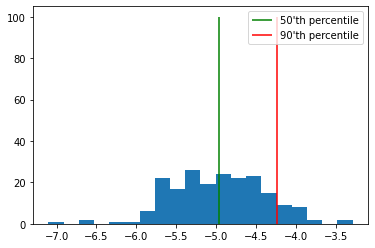

In [68]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [69]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch:  list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states, elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    inds = [i for i,x in enumerate(rewards_batch) if rewards_batch[i] >= reward_threshold]

    elite_states  = [x for i in inds for x in states_batch[i]]
    elite_actions = [x for i in inds for x in actions_batch[i]]

    return elite_states, elite_actions

In [70]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]), \
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_30[1] == [3, 2, 0, 1, 3, 3]), \
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]), \
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]), \
    "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")

Ok!


In [71]:
def update_policy(elite_states, elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    # initialize random policy
    new_policy = initialize_policy(n_states, n_actions)
    unique_states = np.unique(elite_states)
    
    for s in unique_states:
      new_policy[s] = np.zeros((1,n_actions))
    
    for i,s in enumerate(elite_states):
      new_policy[s,elite_actions[i]] += 1

    for s in unique_states:
      new_policy[s] = new_policy[s] / np.sum(new_policy[s])

    # Don't forget to set 1/n_actions for all actions in unvisited states.

    return new_policy

In [72]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(), \
    "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy >= 0), \
    "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1), 1), \
    "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")

Ok!


In [73]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

mean reward = -3.598, threshold=-3.643


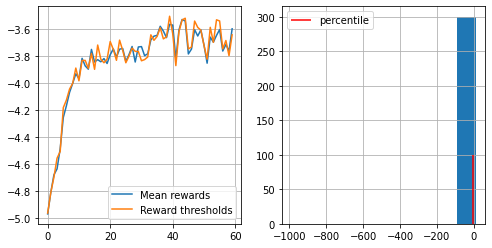

In [74]:
# reset policy just in case
policy = initialize_policy(n_states, n_actions)

n_sessions = 300      # sample this many sessions
percentile = 50       # take this percent of session with highest rewards
learning_rate = 0.25  # how quickly the policy is updated, on a scale from 0 to 1

log = []

epoch = 60
for i in np.arange(epoch):
    %time sessions = [generate_session(env, policy) for i in np.arange(n_sessions) ]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, 
                                                rewards_batch, percentile)
    
    new_policy = update_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)